# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Fri Dec 11 10:40:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   59C    P8    12W / 151W |    312MiB /  8192MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
!dir "D:/Datasets/thesis_dr/aptos2019-blindness-detection/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019-blindness-detection

12/11/2020  12:40 AM    <DIR>          .
12/11/2020  12:40 AM    <DIR>          ..
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
12/06/2020  07:46 AM         1,235,300 df_train_duplicate.csv
12/10/2020  06:51 AM    <DIR>          models
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/18/2019  03:23 AM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/18/2019  03:27 AM            54,948 train.csv
10/10/2020  08:35 AM    <DIR>          train_images
10/30/2020  07:20 PM    <DIR>          train_images_balance_mini
10/28/2020  11:42 PM    <DIR>          train_images_jpeg
12/11/2020  01:07 AM    <DIR>          train_images_rescaled_300
12/11/2020  01:07 AM    <DIR>          train_images_rescaled_300_crop
12/11/2020  01:07 AM    <DIR>          trai

In [5]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019-blindness-detection/'
dir_img = os.path.join(
    dir_base, 'train_images_rescaled_300_enhanced_green_crop_nakhon')

if os.path.isdir(os.path.join(dir_base, 'models/kfold_green/')) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_green/'))

In [6]:
image_shape = (299, 299, 3)
batch_size = 32
lr_init = 1e-4
lr_tune = 2e-6
epoch_init = 50
epoch_tune = 50
# decay_init = lr_init / epoch_init
# decay_tune = lr_tune / epoch_tune
save_csv = 'log_training-20201211.csv'
save_EOE_train_head = 'EOE_classifier-20201211.h5'
save_best_train_head = 'best_classifier-20201211.h5'
save_EOE_train_body = 'EOE_fine_tune-20201211.h5'
save_best_train_body = 'best_fine_tune-20201211.h5'

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

,id_code,diagnosis,is_exist,dhash,freq,keep
0,000c1434d8d7.png,2,True,4505549846649357848361897357201341356077337430...,1,yes
1,001639a390f0.png,4,True,2329637184878609198035515006640525134579216941...,1,yes
2,0024cdab0c1e.png,1,True,2423240825355712633243422248054645083667877231...,1,yes
3,002c21358ce6.png,0,True,6900833685078708622050523299339707984650415156...,1,yes
4,005b95c28852.png,0,True,1596672251484725956711788094558338750112176232...,1,yes
...,...,...,...,...,...,...
3657,ffa47f6a7bf4.png,2,True,1714415029888012417314661111083115996014360412...,1,yes
3658,ffc04fed30e6.png,0,True,1596672252599988637907833311359172559898032526...,1,yes
3659,ffcf7b45f213.png,2,True,2371174750225767638951270617106319090295289270...,1,yes
3660,ffd97f8cd5aa.png,0,True,4495615386714830418073151623371454397778002504...,1,yes


In [8]:
df.groupby('diagnosis')[['id_code']].count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3493,ffa47f6a7bf4.png,2
3494,ffc04fed30e6.png,0
3495,ffcf7b45f213.png,2
3496,ffd97f8cd5aa.png,0


In [10]:
df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1796
1,338
2,921
3,173
4,270


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']
                             ], df.iloc[dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1437
1,271
2,736
3,138
4,216


In [13]:
df_valid.groupby('diagnosis').count()

,id_code
diagnosis,
0,359
1,67
2,185
3,35
4,54


In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Model

In [17]:
def create_model():
    conv_base = InceptionV3(
        include_top=False, weights='imagenet', input_shape=(image_shape))
    conv_base.trainable = False

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512, kernel_initializer=initializers.GlorotUniform(
        seed=123), kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [18]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()]

In [19]:
# define plot function
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='valid loss')
    plt.title('Training & Valid Loss')
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='valid acc')
    plt.title('Training & Valid Accuracy')
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='valid precision')
    plt.title('Training & Valid Precision')
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='valid recall')
    plt.title('Training & Valid Recall')
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label='training auc')
    plt.plot(epochs, val_auc, label='valid auc')
    plt.title('Training & Valid AUC')
    plt.legend()
    plt.show()

# Define Image Generator

In [20]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last')

test_datagen = image.ImageDataGenerator(
    data_format='channels_last')

In [21]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [22]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [23]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [24]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [25]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.png'

In [26]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
3233,ea5c42a78979.png,0


In [27]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

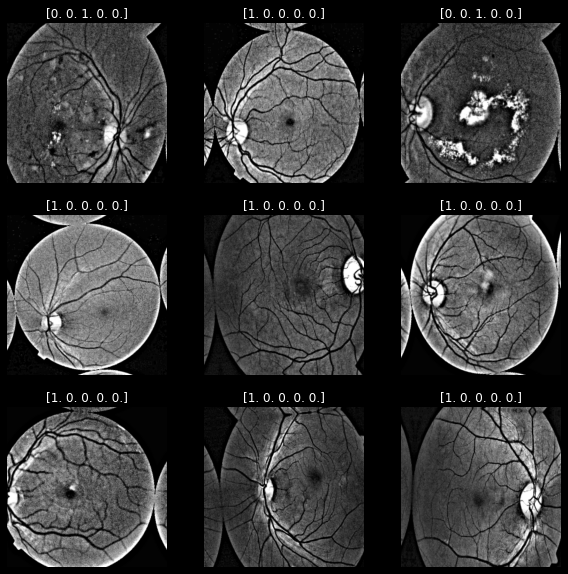

In [28]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [29]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [30]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [31]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.png'

In [32]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
2261,a44345b27804.png,0


In [33]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

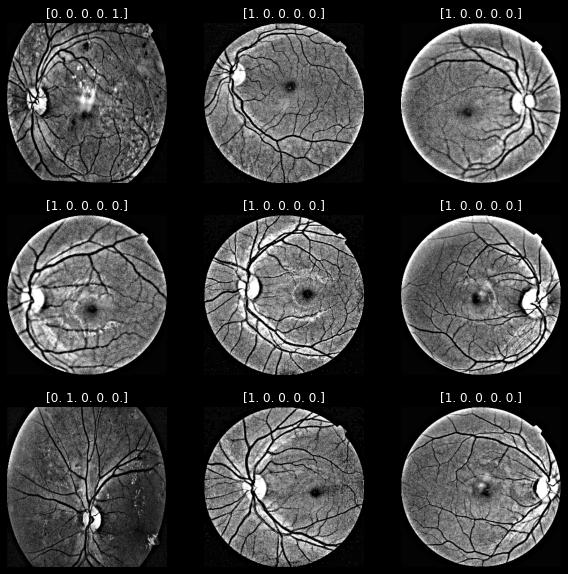

In [34]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Fold 1

## Train classifier

In [35]:
fold = 1
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [36]:
df_valid.head(3)

,id_code,diagnosis
0,000c1434d8d7.png,2
5,0083ee8054ee.png,4
9,00cb6555d108.png,1


In [37]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))

In [38]:
conv_base, model = create_model()

In [39]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [40]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [41]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6993 - categorical_accuracy: 0.4732 - precision: 0.5571 - recall: 0.3742 - auc: 0.7585
Epoch 00001: val_loss improved from inf to 10.11846, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold1\best_classifier-20201211.h5
88/88 [==============================] - 142s 2s/step - loss: 10.6928 - categorical_accuracy: 0.4746 - precision: 0.5582 - recall: 0.3753 - auc: 0.7600 - val_loss: 10.1185 - val_categorical_accuracy: 0.4600 - val_precision: 0.6164 - val_recall: 0.1400 - val_auc: 0.7739
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0662 - categorical_accuracy: 0.5864 - precision: 0.6532 - recall: 0.4964 - auc: 0.8437
Epoch 00002: val_loss improved from 10.11846 to 9.59693, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 4.0541 - categorical_accuracy: 0.6920 - precision: 0.7683 - recall: 0.6150 - auc: 0.9284
Epoch 00028: val_loss improved from 4.08106 to 3.95395, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold1\best_classifier-20201211.h5
88/88 [==============================] - 127s 1s/step - loss: 4.0521 - categorical_accuracy: 0.6923 - precision: 0.7683 - recall: 0.6151 - auc: 0.9287 - val_loss: 3.9540 - val_categorical_accuracy: 0.7714 - val_precision: 0.8348 - val_recall: 0.6857 - val_auc: 0.9524
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.8749 - categorical_accuracy: 0.7263 - precision: 0.7986 - recall: 0.6537 - auc: 0.9392
Epoch 00029: val_loss improved from 3.95395 to 3.83625, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold1\best_classifier-20201211.h5
88/88 [==============================] - 125s 1s/step - loss: 

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.6700 - categorical_accuracy: 0.7158 - precision: 0.7899 - recall: 0.6443 - auc: 0.9400
Epoch 00042: val_loss improved from 2.72501 to 2.67247, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold1\best_classifier-20201211.h5
88/88 [==============================] - 120s 1s/step - loss: 2.6693 - categorical_accuracy: 0.7144 - precision: 0.7888 - recall: 0.6433 - auc: 0.9398 - val_loss: 2.6725 - val_categorical_accuracy: 0.7943 - val_precision: 0.8316 - val_recall: 0.7057 - val_auc: 0.9595
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.5806 - categorical_accuracy: 0.7245 - precision: 0.8010 - recall: 0.6504 - auc: 0.9412
Epoch 00043: val_loss improved from 2.67247 to 2.60851, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold1\best_classifier-20201211.h5
88/88 [==============================] - 120s 1s/step - loss: 

In [42]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

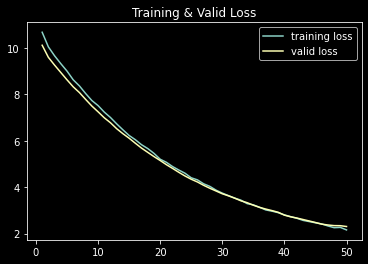

In [43]:
plot_loss(history)

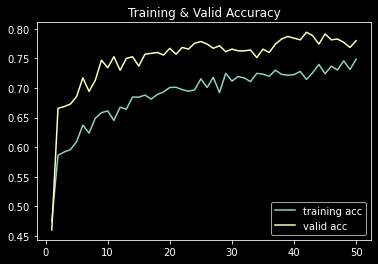

In [44]:
plot_acc(history)

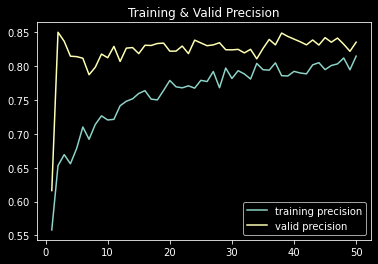

In [45]:
plot_precision(history)

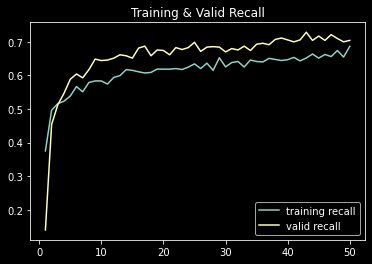

In [46]:
plot_recall(history)

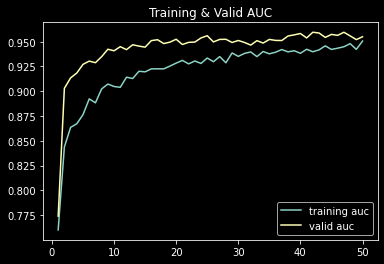

In [47]:
plot_auc(history)

### Evaluate model

In [48]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 539ms/step - loss: 1.9554 - categorical_accuracy: 0.7800 - precision: 0.8356 - recall: 0.7043 - auc: 0.9550


[1.9553699547594243, 0.78, 0.8355932, 0.70428574, 0.9549977]

In [49]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [50]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 440ms/step


In [51]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.98      0.97       359
         mild       0.53      0.34      0.42        67
     moderate       0.70      0.65      0.67       185
       severe       0.36      0.74      0.49        35
proliferative       0.51      0.46      0.49        54

     accuracy                           0.78       700
    macro avg       0.61      0.64      0.61       700
 weighted avg       0.79      0.78      0.78       700



In [52]:
confusion_matrix(y_true, y_pred)

array([[352,   7,   0,   0,   0],
       [  8,  23,  30,   3,   3],
       [  4,  13, 120,  29,  19],
       [  0,   0,   7,  26,   2],
       [  1,   0,  14,  14,  25]], dtype=int64)

## Fine Tune

In [53]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [55]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [56]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.1676 - categorical_accuracy: 0.7469 - precision: 0.8170 - recall: 0.6793 - auc: 0.9488
Epoch 00001: val_loss improved from inf to 2.28517, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold1\best_fine_tune-20201211.h5
88/88 [==============================] - 148s 2s/step - loss: 2.1679 - categorical_accuracy: 0.7477 - precision: 0.8177 - recall: 0.6798 - auc: 0.9488 - val_loss: 2.2852 - val_categorical_accuracy: 0.7843 - val_precision: 0.8370 - val_recall: 0.7114 - val_auc: 0.9565
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.1420 - categorical_accuracy: 0.7444 - precision: 0.8160 - recall: 0.6797 - auc: 0.9489
Epoch 00002: val_loss improved from 2.28517 to 2.27509, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold1\best_

88/88 [==============================] - 130s 1s/step - loss: 2.0656 - categorical_accuracy: 0.7663 - precision: 0.8361 - recall: 0.6966 - auc: 0.9545 - val_loss: 2.2139 - val_categorical_accuracy: 0.8000 - val_precision: 0.8336 - val_recall: 0.7371 - val_auc: 0.9618
Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 2.0771 - categorical_accuracy: 0.7726 - precision: 0.8306 - recall: 0.7039 - auc: 0.9555
Epoch 00015: val_loss did not improve from 2.21386
88/88 [==============================] - 130s 1s/step - loss: 2.0740 - categorical_accuracy: 0.7727 - precision: 0.8309 - recall: 0.7044 - auc: 0.9558 - val_loss: 2.2139 - val_categorical_accuracy: 0.7957 - val_precision: 0.8325 - val_recall: 0.7386 - val_auc: 0.9619
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.1165 - categorical_accuracy: 0.7516 - precision: 0.8075 - recall: 0.6826 - auc: 0.9509
Epoch 00016: val_loss improved from 2.21386 to 2.21093, saving model to D:/Datasets/thesis_dr/apt

Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 2.0231 - categorical_accuracy: 0.7802 - precision: 0.8276 - recall: 0.7101 - auc: 0.9583
Epoch 00029: val_loss did not improve from 2.18604
88/88 [==============================] - 122s 1s/step - loss: 2.0200 - categorical_accuracy: 0.7809 - precision: 0.8283 - recall: 0.7102 - auc: 0.9585 - val_loss: 2.1933 - val_categorical_accuracy: 0.7971 - val_precision: 0.8328 - val_recall: 0.7543 - val_auc: 0.9627
Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 1.9886 - categorical_accuracy: 0.7769 - precision: 0.8319 - recall: 0.7104 - auc: 0.9584
Epoch 00030: val_loss did not improve from 2.18604
88/88 [==============================] - 123s 1s/step - loss: 1.9933 - categorical_accuracy: 0.7770 - precision: 0.8313 - recall: 0.7098 - auc: 0.9582 - val_loss: 2.1938 - val_categorical_accuracy: 0.7957 - val_precision: 0.8302 - val_recall: 0.7543 - val_auc: 0.9625
Epoch 31/50
87/88 [===========================

Epoch 45/50
87/88 [============================>.] - ETA: 1s - loss: 1.9299 - categorical_accuracy: 0.7871 - precision: 0.8478 - recall: 0.7270 - auc: 0.9644
Epoch 00045: val_loss did not improve from 2.16068
88/88 [==============================] - 119s 1s/step - loss: 1.9299 - categorical_accuracy: 0.7877 - precision: 0.8480 - recall: 0.7277 - auc: 0.9643 - val_loss: 2.1640 - val_categorical_accuracy: 0.8071 - val_precision: 0.8414 - val_recall: 0.7657 - val_auc: 0.9642
Epoch 46/50
87/88 [============================>.] - ETA: 1s - loss: 1.9440 - categorical_accuracy: 0.7896 - precision: 0.8345 - recall: 0.7292 - auc: 0.9621
Epoch 00046: val_loss did not improve from 2.16068
88/88 [==============================] - 118s 1s/step - loss: 1.9490 - categorical_accuracy: 0.7884 - precision: 0.8340 - recall: 0.7273 - auc: 0.9618 - val_loss: 2.1680 - val_categorical_accuracy: 0.8086 - val_precision: 0.8404 - val_recall: 0.7671 - val_auc: 0.9645
Epoch 47/50
87/88 [===========================

In [57]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

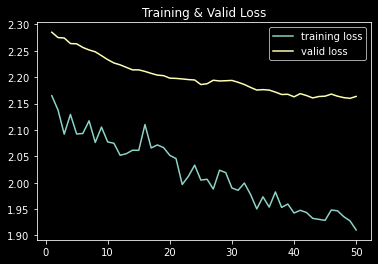

In [58]:
plot_loss(history)

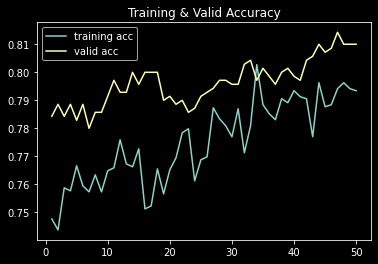

In [59]:
plot_acc(history)

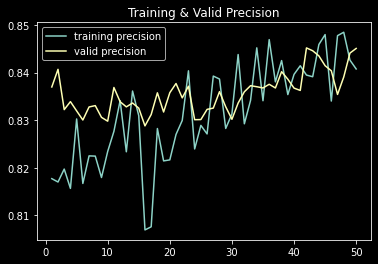

In [60]:
plot_precision(history)

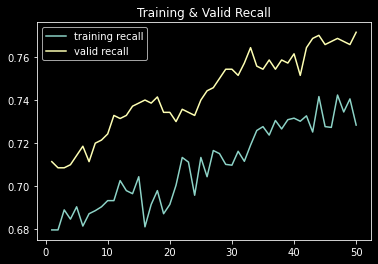

In [61]:
plot_recall(history)

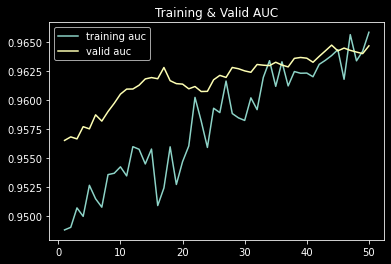

In [62]:
plot_auc(history)

### Evaluate model

In [63]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 485ms/step - loss: 1.8163 - categorical_accuracy: 0.8100 - precision: 0.8451 - recall: 0.7714 - auc: 0.9647


[1.8163266615434126, 0.81, 0.8450704, 0.7714286, 0.96465844]

In [64]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [65]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 464ms/step


In [66]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.98      0.98       359
         mild       0.59      0.55      0.57        67
     moderate       0.74      0.69      0.72       185
       severe       0.43      0.69      0.53        35
proliferative       0.58      0.46      0.52        54

     accuracy                           0.81       700
    macro avg       0.66      0.68      0.66       700
 weighted avg       0.81      0.81      0.81       700



In [67]:
confusion_matrix(y_true, y_pred)

array([[353,   6,   0,   0,   0],
       [  7,  37,  21,   1,   1],
       [  4,  20, 128,  18,  15],
       [  0,   0,   9,  24,   2],
       [  1,   0,  15,  13,  25]], dtype=int64)

# Fold 2

## Train classifier

In [68]:
del(model)

In [69]:
fold = 2
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [70]:
df_valid.head(3)

,id_code,diagnosis
1,001639a390f0.png,4
3,002c21358ce6.png,0
11,00e4ddff966a.png,2


In [71]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))

In [72]:
conv_base, model = create_model()

In [73]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [74]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [75]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6695 - categorical_accuracy: 0.4787 - precision: 0.5568 - recall: 0.3847 - auc: 0.7628
Epoch 00001: val_loss improved from inf to 10.11616, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_classifier-20201211.h5
88/88 [==============================] - 136s 2s/step - loss: 10.6645 - categorical_accuracy: 0.4793 - precision: 0.5573 - recall: 0.3856 - auc: 0.7639 - val_loss: 10.1162 - val_categorical_accuracy: 0.5629 - val_precision: 0.7169 - val_recall: 0.2786 - val_auc: 0.8354
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0496 - categorical_accuracy: 0.5792 - precision: 0.6532 - recall: 0.4971 - auc: 0.8421
Epoch 00002: val_loss improved from 10.11616 to 9.62058, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.9335 - categorical_accuracy: 0.6985 - precision: 0.7710 - recall: 0.6258 - auc: 0.9338
Epoch 00028: val_loss improved from 4.09246 to 3.98382, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_classifier-20201211.h5
88/88 [==============================] - 122s 1s/step - loss: 3.9314 - categorical_accuracy: 0.6998 - precision: 0.7718 - recall: 0.6272 - auc: 0.9341 - val_loss: 3.9838 - val_categorical_accuracy: 0.7543 - val_precision: 0.8177 - val_recall: 0.6729 - val_auc: 0.9486
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7554 - categorical_accuracy: 0.7187 - precision: 0.7895 - recall: 0.6497 - auc: 0.9418
Epoch 00029: val_loss improved from 3.98382 to 3.84565, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_classifier-20201211.h5
88/88 [==============================] - 124s 1s/step - loss: 

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.5684 - categorical_accuracy: 0.7368 - precision: 0.8040 - recall: 0.6645 - auc: 0.9452
Epoch 00042: val_loss improved from 2.77137 to 2.71850, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_classifier-20201211.h5
88/88 [==============================] - 128s 1s/step - loss: 2.5684 - categorical_accuracy: 0.7373 - precision: 0.8049 - recall: 0.6651 - auc: 0.9453 - val_loss: 2.7185 - val_categorical_accuracy: 0.7471 - val_precision: 0.8038 - val_recall: 0.6671 - val_auc: 0.9477
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4980 - categorical_accuracy: 0.7346 - precision: 0.7973 - recall: 0.6670 - auc: 0.9473
Epoch 00043: val_loss improved from 2.71850 to 2.63552, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_classifier-20201211.h5
88/88 [==============================] - 124s 1s/step - loss: 

In [76]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

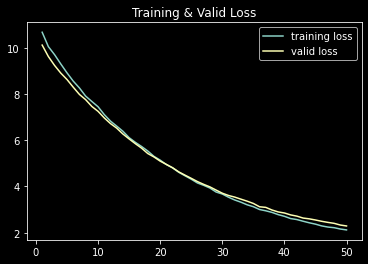

In [77]:
plot_loss(history)

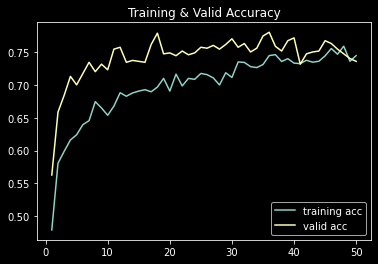

In [78]:
plot_acc(history)

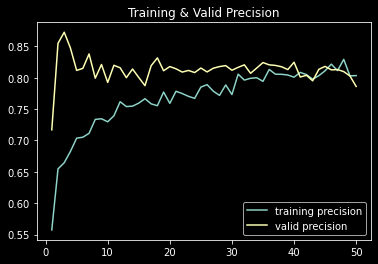

In [79]:
plot_precision(history)

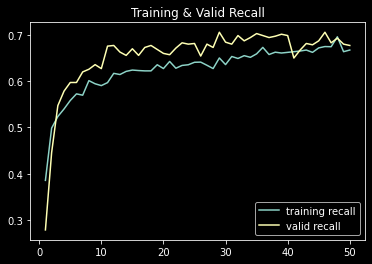

In [80]:
plot_recall(history)

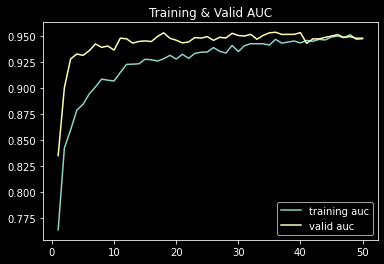

In [81]:
plot_auc(history)

### Evaluate model

In [82]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 502ms/step - loss: 1.9380 - categorical_accuracy: 0.7357 - precision: 0.7861 - recall: 0.6771 - auc: 0.9484


[1.938031949780204, 0.73571426, 0.78606963, 0.67714286, 0.948387]

In [83]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [84]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 441ms/step


In [85]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.95      0.96       359
         mild       0.46      0.46      0.46        68
     moderate       0.68      0.54      0.60       184
       severe       0.31      0.46      0.37        35
proliferative       0.34      0.50      0.41        54

     accuracy                           0.74       700
    macro avg       0.55      0.58      0.56       700
 weighted avg       0.76      0.74      0.74       700



In [86]:
confusion_matrix(y_true, y_pred)

array([[342,   8,   5,   0,   4],
       [  8,  31,  24,   2,   3],
       [  5,  26,  99,  23,  31],
       [  1,   0,   4,  16,  14],
       [  0,   2,  14,  11,  27]], dtype=int64)

## Fine Tune

In [87]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [88]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [89]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [90]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0445 - categorical_accuracy: 0.7523 - precision: 0.8088 - recall: 0.6743 - auc: 0.9504
Epoch 00001: val_loss improved from inf to 2.30469, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_fine_tune-20201211.h5
88/88 [==============================] - 147s 2s/step - loss: 2.0457 - categorical_accuracy: 0.7520 - precision: 0.8077 - recall: 0.6741 - auc: 0.9504 - val_loss: 2.3047 - val_categorical_accuracy: 0.7386 - val_precision: 0.7974 - val_recall: 0.6914 - val_auc: 0.9503
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0527 - categorical_accuracy: 0.7495 - precision: 0.8187 - recall: 0.6826 - auc: 0.9510
Epoch 00002: val_loss did not improve from 2.30469
88/88 [==============================] - 122s 1s/step - loss: 2.0496 - categorical_accuracy: 0.7513 - p

Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.9864 - categorical_accuracy: 0.7777 - precision: 0.8300 - recall: 0.7061 - auc: 0.9577
Epoch 00016: val_loss improved from 2.27727 to 2.27066, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_fine_tune-20201211.h5
88/88 [==============================] - 126s 1s/step - loss: 1.9850 - categorical_accuracy: 0.7781 - precision: 0.8302 - recall: 0.7059 - auc: 0.9579 - val_loss: 2.2707 - val_categorical_accuracy: 0.7657 - val_precision: 0.8068 - val_recall: 0.7157 - val_auc: 0.9529
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.9688 - categorical_accuracy: 0.7820 - precision: 0.8362 - recall: 0.7162 - auc: 0.9603
Epoch 00017: val_loss improved from 2.27066 to 2.26896, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_fine_tune-20201211.h5
88/88 [==============================] - 128s 1s/step - loss: 1.

Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.8939 - categorical_accuracy: 0.7936 - precision: 0.8453 - recall: 0.7346 - auc: 0.9655
Epoch 00031: val_loss did not improve from 2.22734
88/88 [==============================] - 124s 1s/step - loss: 1.8961 - categorical_accuracy: 0.7927 - precision: 0.8442 - recall: 0.7337 - auc: 0.9654 - val_loss: 2.2329 - val_categorical_accuracy: 0.7886 - val_precision: 0.8228 - val_recall: 0.7429 - val_auc: 0.9561
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.9050 - categorical_accuracy: 0.7863 - precision: 0.8403 - recall: 0.7303 - auc: 0.9637
Epoch 00032: val_loss did not improve from 2.22734
88/88 [==============================] - 124s 1s/step - loss: 1.9059 - categorical_accuracy: 0.7859 - precision: 0.8400 - recall: 0.7298 - auc: 0.9635 - val_loss: 2.2385 - val_categorical_accuracy: 0.7886 - val_precision: 0.8238 - val_recall: 0.7414 - val_auc: 0.9563
Epoch 33/50
87/88 [===========================

Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.8584 - categorical_accuracy: 0.7920 - precision: 0.8423 - recall: 0.7425 - auc: 0.9664
Epoch 00048: val_loss did not improve from 2.22502
88/88 [==============================] - 119s 1s/step - loss: 1.8532 - categorical_accuracy: 0.7927 - precision: 0.8428 - recall: 0.7434 - auc: 0.9665 - val_loss: 2.2282 - val_categorical_accuracy: 0.7843 - val_precision: 0.8220 - val_recall: 0.7457 - val_auc: 0.9564
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.8623 - categorical_accuracy: 0.8040 - precision: 0.8472 - recall: 0.7415 - auc: 0.9659
Epoch 00049: val_loss improved from 2.22502 to 2.22250, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold2\best_fine_tune-20201211.h5
88/88 [==============================] - 122s 1s/step - loss: 1.8605 - categorical_accuracy: 0.8041 - precision: 0.8472 - recall: 0.7409 - auc: 0.9658 - val_loss: 2.2225 - val_categorical_a

In [91]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

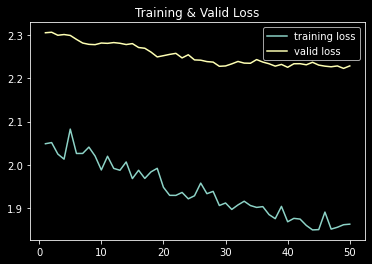

In [92]:
plot_loss(history)

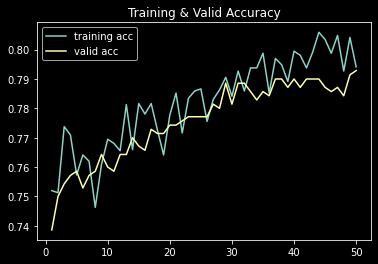

In [93]:
plot_acc(history)

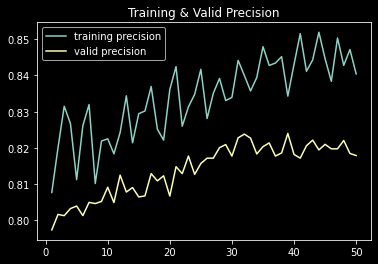

In [94]:
plot_precision(history)

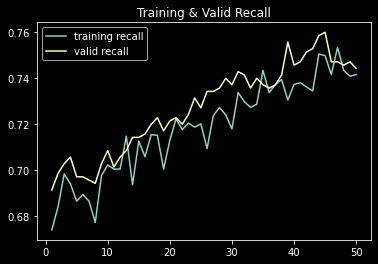

In [95]:
plot_recall(history)

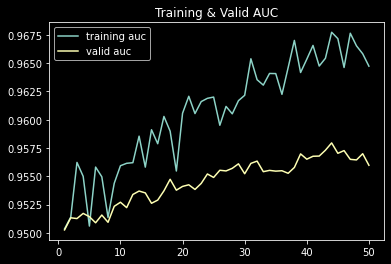

In [96]:
plot_auc(history)

### Evaluate model

In [97]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 493ms/step - loss: 1.8252 - categorical_accuracy: 0.7929 - precision: 0.8179 - recall: 0.7443 - auc: 0.9560


[1.82518992098895, 0.79285717, 0.81789637, 0.7442857, 0.95597804]

In [98]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [99]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 9s 427ms/step


In [100]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.98      0.97       359
         mild       0.57      0.50      0.53        68
     moderate       0.72      0.64      0.68       184
       severe       0.42      0.63      0.51        35
proliferative       0.48      0.56      0.52        54

     accuracy                           0.79       700
    macro avg       0.63      0.66      0.64       700
 weighted avg       0.80      0.79      0.79       700



In [101]:
confusion_matrix(y_true, y_pred)

array([[351,   2,   5,   0,   1],
       [  7,  34,  24,   1,   2],
       [  4,  20, 118,  23,  19],
       [  1,   0,   2,  22,  10],
       [  0,   4,  14,   6,  30]], dtype=int64)

# Fold 3

## Train classifier

In [102]:
del(model)

In [103]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [104]:
df_valid.head(3)

,id_code,diagnosis
2,0024cdab0c1e.png,1
12,00f6c1be5a33.png,0
18,0151781fe50b.png,0


In [105]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))

In [106]:
conv_base, model = create_model()

In [107]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [108]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [109]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6769 - categorical_accuracy: 0.5000 - precision: 0.5775 - recall: 0.4013 - auc: 0.7770
Epoch 00001: val_loss improved from inf to 10.16809, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold3\best_classifier-20201211.h5
88/88 [==============================] - 134s 2s/step - loss: 10.6685 - categorical_accuracy: 0.5007 - precision: 0.5782 - recall: 0.4028 - auc: 0.7779 - val_loss: 10.1681 - val_categorical_accuracy: 0.5186 - val_precision: 0.6544 - val_recall: 0.2029 - val_auc: 0.7937
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0751 - categorical_accuracy: 0.5734 - precision: 0.6569 - recall: 0.4881 - auc: 0.8432
Epoch 00002: val_loss improved from 10.16809 to 9.62441, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.9339 - categorical_accuracy: 0.7144 - precision: 0.7820 - recall: 0.6406 - auc: 0.9364
Epoch 00028: val_loss improved from 4.17142 to 4.02256, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold3\best_classifier-20201211.h5
88/88 [==============================] - 122s 1s/step - loss: 3.9342 - categorical_accuracy: 0.7144 - precision: 0.7818 - recall: 0.6401 - auc: 0.9364 - val_loss: 4.0226 - val_categorical_accuracy: 0.7543 - val_precision: 0.8082 - val_recall: 0.6743 - val_auc: 0.9460
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.8124 - categorical_accuracy: 0.7231 - precision: 0.7900 - recall: 0.6377 - auc: 0.9366
Epoch 00029: val_loss improved from 4.02256 to 3.92596, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold3\best_classifier-20201211.h5
88/88 [==============================] - 128s 1s/step - loss: 

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.5790 - categorical_accuracy: 0.7448 - precision: 0.8074 - recall: 0.6699 - auc: 0.9487
Epoch 00042: val_loss improved from 2.86045 to 2.73117, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold3\best_classifier-20201211.h5
88/88 [==============================] - 121s 1s/step - loss: 2.5742 - categorical_accuracy: 0.7441 - precision: 0.8067 - recall: 0.6698 - auc: 0.9486 - val_loss: 2.7312 - val_categorical_accuracy: 0.7629 - val_precision: 0.8227 - val_recall: 0.6829 - val_auc: 0.9512
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4996 - categorical_accuracy: 0.7469 - precision: 0.8104 - recall: 0.6674 - auc: 0.9492
Epoch 00043: val_loss improved from 2.73117 to 2.73010, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold3\best_classifier-20201211.h5
88/88 [==============================] - 121s 1s/step - loss: 

In [110]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

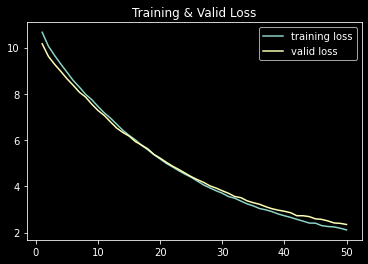

In [111]:
plot_loss(history)

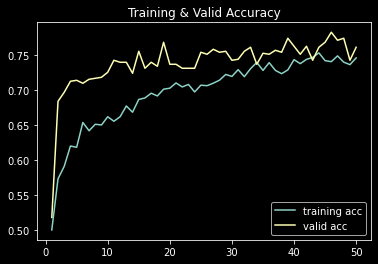

In [112]:
plot_acc(history)

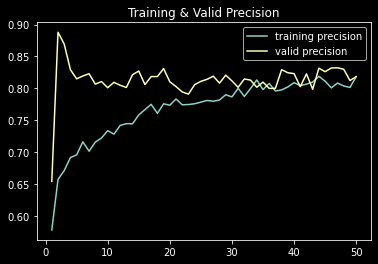

In [113]:
plot_precision(history)

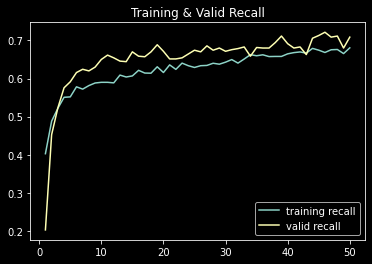

In [114]:
plot_recall(history)

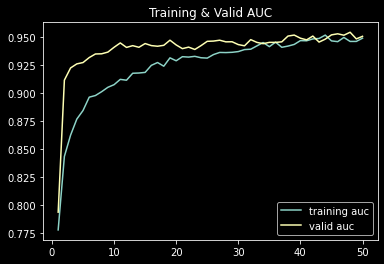

In [115]:
plot_auc(history)

### Evaluate model

In [116]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 505ms/step - loss: 1.9362 - categorical_accuracy: 0.7614 - precision: 0.8185 - recall: 0.7086 - auc: 0.9510


[1.936225089159879, 0.7614286, 0.81848186, 0.70857143, 0.9509561]

In [117]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [118]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 432ms/step


In [119]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.93      0.98      0.95       359
         mild       0.54      0.41      0.47        68
     moderate       0.68      0.58      0.63       184
       severe       0.30      0.54      0.38        35
proliferative       0.56      0.50      0.53        54

     accuracy                           0.76       700
    macro avg       0.60      0.60      0.59       700
 weighted avg       0.77      0.76      0.76       700



In [120]:
confusion_matrix(y_true, y_pred)

array([[352,   4,   3,   0,   0],
       [ 16,  28,  20,   1,   3],
       [ 11,  17, 107,  34,  15],
       [  0,   1,  12,  19,   3],
       [  0,   2,  15,  10,  27]], dtype=int64)

## Fine Tune

In [121]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [122]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [123]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [124]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0906 - categorical_accuracy: 0.7390 - precision: 0.8008 - recall: 0.6743 - auc: 0.9492
Epoch 00001: val_loss improved from inf to 2.36760, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold3\best_fine_tune-20201211.h5
88/88 [==============================] - 140s 2s/step - loss: 2.0870 - categorical_accuracy: 0.7398 - precision: 0.8019 - recall: 0.6755 - auc: 0.9495 - val_loss: 2.3676 - val_categorical_accuracy: 0.7614 - val_precision: 0.8186 - val_recall: 0.7157 - val_auc: 0.9517
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0869 - categorical_accuracy: 0.7415 - precision: 0.8085 - recall: 0.6761 - auc: 0.9482
Epoch 00002: val_loss improved from 2.36760 to 2.35884, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold3\best_

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 2.0020 - categorical_accuracy: 0.7751 - precision: 0.8240 - recall: 0.7039 - auc: 0.9580
Epoch 00015: val_loss did not improve from 2.32031
88/88 [==============================] - 119s 1s/step - loss: 2.0069 - categorical_accuracy: 0.7748 - precision: 0.8231 - recall: 0.7034 - auc: 0.9579 - val_loss: 2.3258 - val_categorical_accuracy: 0.7686 - val_precision: 0.8242 - val_recall: 0.7300 - val_auc: 0.9545
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.9907 - categorical_accuracy: 0.7762 - precision: 0.8375 - recall: 0.7195 - auc: 0.9588
Epoch 00016: val_loss did not improve from 2.32031
88/88 [==============================] - 120s 1s/step - loss: 1.9926 - categorical_accuracy: 0.7770 - precision: 0.8381 - recall: 0.7198 - auc: 0.9589 - val_loss: 2.3226 - val_categorical_accuracy: 0.7657 - val_precision: 0.8210 - val_recall: 0.7271 - val_auc: 0.9547
Epoch 17/50
87/88 [===========================

Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.9511 - categorical_accuracy: 0.7748 - precision: 0.8324 - recall: 0.7202 - auc: 0.9608
Epoch 00032: val_loss improved from 2.29950 to 2.29192, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold3\best_fine_tune-20201211.h5
88/88 [==============================] - 125s 1s/step - loss: 1.9519 - categorical_accuracy: 0.7738 - precision: 0.8320 - recall: 0.7187 - auc: 0.9607 - val_loss: 2.2919 - val_categorical_accuracy: 0.7814 - val_precision: 0.8279 - val_recall: 0.7286 - val_auc: 0.9562
Epoch 33/50
87/88 [============================>.] - ETA: 1s - loss: 1.9409 - categorical_accuracy: 0.7816 - precision: 0.8273 - recall: 0.7310 - auc: 0.9606
Epoch 00033: val_loss did not improve from 2.29192
88/88 [==============================] - 122s 1s/step - loss: 1.9415 - categorical_accuracy: 0.7816 - precision: 0.8272 - recall: 0.7305 - auc: 0.9607 - val_loss: 2.2990 - val_categorical_a

In [125]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

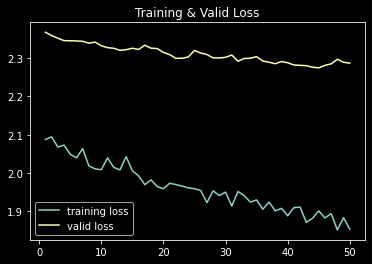

In [126]:
plot_loss(history)

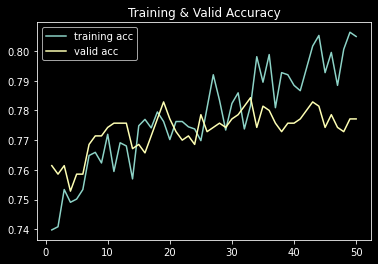

In [127]:
plot_acc(history)

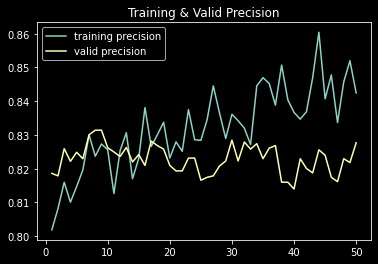

In [128]:
plot_precision(history)

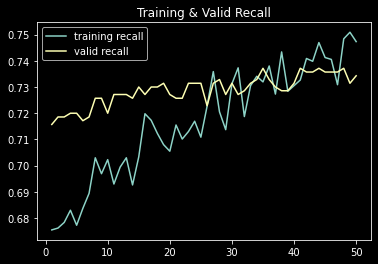

In [129]:
plot_recall(history)

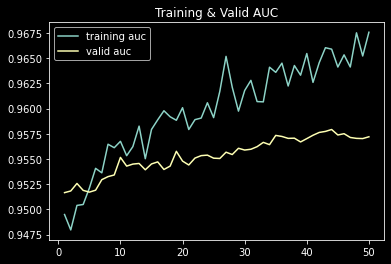

In [130]:
plot_auc(history)

### Evaluate model

In [131]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 502ms/step - loss: 1.8358 - categorical_accuracy: 0.7771 - precision: 0.8277 - recall: 0.7343 - auc: 0.9572


[1.8358383666385303, 0.7771429, 0.8276973, 0.7342857, 0.95720506]

In [132]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [133]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 438ms/step


In [134]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.98      0.96       359
         mild       0.54      0.44      0.48        68
     moderate       0.70      0.62      0.66       184
       severe       0.30      0.43      0.35        35
proliferative       0.54      0.57      0.56        54

     accuracy                           0.78       700
    macro avg       0.61      0.61      0.60       700
 weighted avg       0.78      0.78      0.78       700



In [135]:
confusion_matrix(y_true, y_pred)

array([[353,   4,   2,   0,   0],
       [ 13,  30,  21,   1,   3],
       [  7,  19, 115,  28,  15],
       [  0,   1,  11,  15,   8],
       [  0,   2,  15,   6,  31]], dtype=int64)

# Fold 4

## Train classifier

In [136]:
del(model)

In [137]:
fold = 4
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [138]:
df_valid.head(3)

,id_code,diagnosis
4,005b95c28852.png,0
10,00cc2b75cddd.png,0
13,0104b032c141.png,3


In [139]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))

In [140]:
conv_base, model = create_model()

In [141]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [142]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [143]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6837 - categorical_accuracy: 0.4731 - precision: 0.5565 - recall: 0.3860 - auc: 0.7614
Epoch 00001: val_loss improved from inf to 10.15753, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold4\best_classifier-20201211.h5
88/88 [==============================] - 142s 2s/step - loss: 10.6755 - categorical_accuracy: 0.4745 - precision: 0.5580 - recall: 0.3869 - auc: 0.7627 - val_loss: 10.1575 - val_categorical_accuracy: 0.5794 - val_precision: 0.7364 - val_recall: 0.2518 - val_auc: 0.8276
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0385 - categorical_accuracy: 0.5793 - precision: 0.6610 - recall: 0.5074 - auc: 0.8472
Epoch 00002: val_loss improved from 10.15753 to 9.63858, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.9446 - categorical_accuracy: 0.7141 - precision: 0.7893 - recall: 0.6444 - auc: 0.9355
Epoch 00028: val_loss improved from 4.10612 to 3.97331, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold4\best_classifier-20201211.h5
88/88 [==============================] - 123s 1s/step - loss: 3.9388 - categorical_accuracy: 0.7156 - precision: 0.7906 - recall: 0.6459 - auc: 0.9360 - val_loss: 3.9733 - val_categorical_accuracy: 0.7439 - val_precision: 0.8123 - val_recall: 0.6624 - val_auc: 0.9471
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7941 - categorical_accuracy: 0.7116 - precision: 0.7881 - recall: 0.6411 - auc: 0.9382
Epoch 00029: val_loss improved from 3.97331 to 3.86107, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold4\best_classifier-20201211.h5
88/88 [==============================] - 121s 1s/step - loss: 

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.5729 - categorical_accuracy: 0.7351 - precision: 0.8025 - recall: 0.6625 - auc: 0.9466
Epoch 00042: val_loss improved from 2.79888 to 2.77735, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold4\best_classifier-20201211.h5
88/88 [==============================] - 121s 1s/step - loss: 2.5734 - categorical_accuracy: 0.7353 - precision: 0.8034 - recall: 0.6627 - auc: 0.9468 - val_loss: 2.7774 - val_categorical_accuracy: 0.7439 - val_precision: 0.8140 - val_recall: 0.6824 - val_auc: 0.9482
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4938 - categorical_accuracy: 0.7467 - precision: 0.8154 - recall: 0.6610 - auc: 0.9482
Epoch 00043: val_loss improved from 2.77735 to 2.68001, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold4\best_classifier-20201211.h5
88/88 [==============================] - 121s 1s/step - loss: 

In [144]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

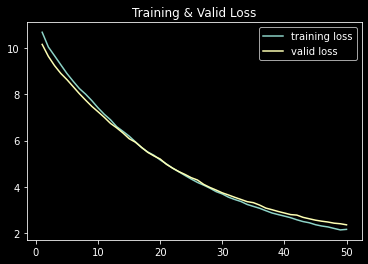

In [145]:
plot_loss(history)

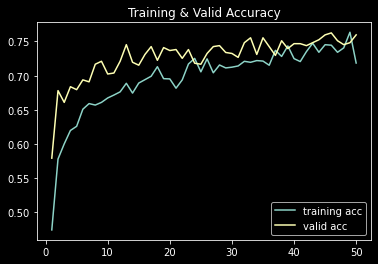

In [146]:
plot_acc(history)

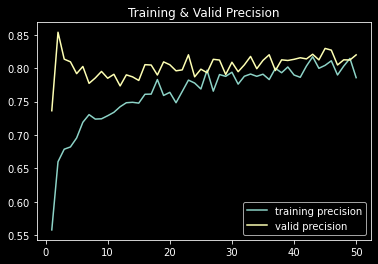

In [147]:
plot_precision(history)

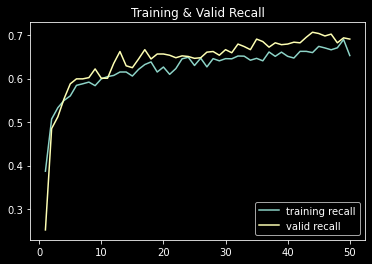

In [148]:
plot_recall(history)

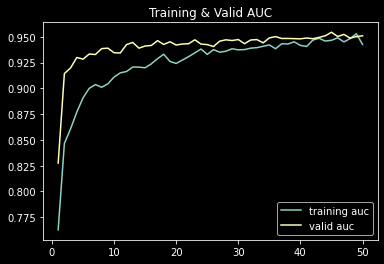

In [149]:
plot_auc(history)

### Evaluate model

In [150]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 624ms/step - loss: 1.9307 - categorical_accuracy: 0.7597 - precision: 0.8200 - recall: 0.6910 - auc: 0.9510


[1.9307146614248103, 0.75965667, 0.82003397, 0.6909871, 0.95099705]

In [151]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [152]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 9s 422ms/step


In [153]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.98      0.96       359
         mild       0.46      0.50      0.48        68
     moderate       0.72      0.58      0.64       184
       severe       0.32      0.50      0.39        34
proliferative       0.47      0.43      0.45        54

     accuracy                           0.76       699
    macro avg       0.58      0.60      0.58       699
 weighted avg       0.77      0.76      0.76       699



In [154]:
confusion_matrix(y_true, y_pred)

array([[351,   6,   1,   1,   0],
       [ 10,  34,  21,   2,   1],
       [ 12,  31, 106,  19,  16],
       [  0,   1,   7,  17,   9],
       [  2,   2,  13,  14,  23]], dtype=int64)

## Fine Tune

In [155]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [156]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [157]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [158]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0723 - categorical_accuracy: 0.7647 - precision: 0.8248 - recall: 0.6910 - auc: 0.9552
Epoch 00001: val_loss improved from inf to 2.36070, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold4\best_fine_tune-20201211.h5
88/88 [==============================] - 138s 2s/step - loss: 2.0695 - categorical_accuracy: 0.7660 - precision: 0.8263 - recall: 0.6917 - auc: 0.9555 - val_loss: 2.3607 - val_categorical_accuracy: 0.7654 - val_precision: 0.8197 - val_recall: 0.6896 - val_auc: 0.9514
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0444 - categorical_accuracy: 0.7662 - precision: 0.8248 - recall: 0.6892 - auc: 0.9557
Epoch 00002: val_loss improved from 2.36070 to 2.34546, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold4\best_

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 1.9643 - categorical_accuracy: 0.7734 - precision: 0.8361 - recall: 0.7116 - auc: 0.9608
Epoch 00015: val_loss did not improve from 2.30727
88/88 [==============================] - 119s 1s/step - loss: 1.9680 - categorical_accuracy: 0.7742 - precision: 0.8366 - recall: 0.7117 - auc: 0.9609 - val_loss: 2.3086 - val_categorical_accuracy: 0.7697 - val_precision: 0.8322 - val_recall: 0.7167 - val_auc: 0.9533
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0162 - categorical_accuracy: 0.7618 - precision: 0.8150 - recall: 0.6975 - auc: 0.9548
Epoch 00016: val_loss improved from 2.30727 to 2.30634, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold4\best_fine_tune-20201211.h5
88/88 [==============================] - 123s 1s/step - loss: 2.0119 - categorical_accuracy: 0.7624 - precision: 0.8161 - recall: 0.6977 - auc: 0.9551 - val_loss: 2.3063 - val_categorical_a

Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 1.9059 - categorical_accuracy: 0.8063 - precision: 0.8567 - recall: 0.7434 - auc: 0.9656
Epoch 00030: val_loss did not improve from 2.27774
88/88 [==============================] - 119s 1s/step - loss: 1.9067 - categorical_accuracy: 0.8060 - precision: 0.8559 - recall: 0.7428 - auc: 0.9654 - val_loss: 2.2789 - val_categorical_accuracy: 0.7897 - val_precision: 0.8411 - val_recall: 0.7496 - val_auc: 0.9567
Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.9154 - categorical_accuracy: 0.7886 - precision: 0.8356 - recall: 0.7311 - auc: 0.9637
Epoch 00031: val_loss did not improve from 2.27774
88/88 [==============================] - 120s 1s/step - loss: 1.9186 - categorical_accuracy: 0.7867 - precision: 0.8347 - recall: 0.7288 - auc: 0.9633 - val_loss: 2.2794 - val_categorical_accuracy: 0.7940 - val_precision: 0.8459 - val_recall: 0.7539 - val_auc: 0.9573
Epoch 32/50
87/88 [===========================

In [159]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

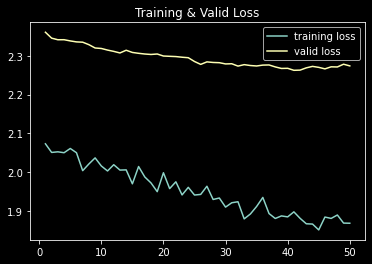

In [160]:
plot_loss(history)

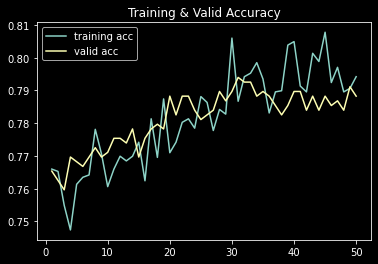

In [161]:
plot_acc(history)

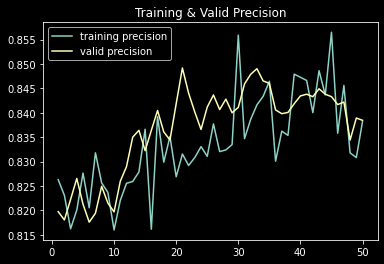

In [162]:
plot_precision(history)

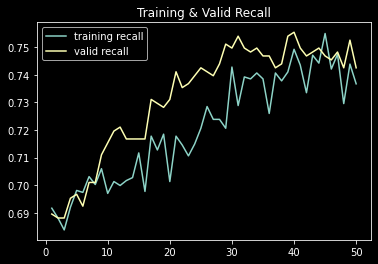

In [163]:
plot_recall(history)

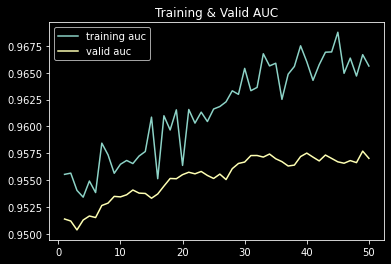

In [164]:
plot_auc(history)

### Evaluate model

In [165]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 491ms/step - loss: 1.8373 - categorical_accuracy: 0.7883 - precision: 0.8384 - recall: 0.7425 - auc: 0.9570


[1.8373418287797407, 0.788269, 0.8384491, 0.7424893, 0.9570227]

In [166]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [167]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 435ms/step


In [168]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.98      0.96       359
         mild       0.59      0.50      0.54        68
     moderate       0.73      0.65      0.69       184
       severe       0.34      0.59      0.43        34
proliferative       0.55      0.44      0.49        54

     accuracy                           0.79       699
    macro avg       0.63      0.63      0.62       699
 weighted avg       0.79      0.79      0.79       699



In [169]:
confusion_matrix(y_true, y_pred)

array([[353,   5,   1,   0,   0],
       [  9,  34,  20,   2,   3],
       [ 12,  18, 120,  23,  11],
       [  0,   0,   8,  20,   6],
       [  1,   1,  15,  13,  24]], dtype=int64)

# Fold 5

## Train classifier

In [170]:
del(model)

In [171]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [172]:
df_valid.head(3)

,id_code,diagnosis
6,0097f532ac9f.png,0
7,00a8624548a9.png,2
8,00b74780d31d.png,2


In [173]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_green/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_green/fold'+str(fold))

In [174]:
conv_base, model = create_model()

In [175]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [176]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [177]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7018 - categorical_accuracy: 0.4767 - precision: 0.5517 - recall: 0.3802 - auc: 0.7625
Epoch 00001: val_loss improved from inf to 10.10404, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold5\best_classifier-20201211.h5
88/88 [==============================] - 136s 2s/step - loss: 10.6955 - categorical_accuracy: 0.4780 - precision: 0.5534 - recall: 0.3812 - auc: 0.7631 - val_loss: 10.1040 - val_categorical_accuracy: 0.6223 - val_precision: 0.8240 - val_recall: 0.2947 - val_auc: 0.8627
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0253 - categorical_accuracy: 0.5768 - precision: 0.6617 - recall: 0.4933 - auc: 0.8455
Epoch 00002: val_loss improved from 10.10404 to 9.58647, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.8936 - categorical_accuracy: 0.7134 - precision: 0.7773 - recall: 0.6408 - auc: 0.9360
Epoch 00028: val_loss improved from 4.08526 to 3.95397, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold5\best_classifier-20201211.h5
88/88 [==============================] - 122s 1s/step - loss: 3.8895 - categorical_accuracy: 0.7156 - precision: 0.7790 - recall: 0.6424 - auc: 0.9367 - val_loss: 3.9540 - val_categorical_accuracy: 0.7268 - val_precision: 0.8094 - val_recall: 0.6381 - val_auc: 0.9412
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7508 - categorical_accuracy: 0.7235 - precision: 0.7823 - recall: 0.6520 - auc: 0.9398
Epoch 00029: val_loss improved from 3.95397 to 3.84423, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold5\best_classifier-20201211.h5
88/88 [==============================] - 123s 1s/step - loss: 

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.4928 - categorical_accuracy: 0.7474 - precision: 0.8088 - recall: 0.6802 - auc: 0.9487
Epoch 00042: val_loss improved from 2.83820 to 2.74036, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold5\best_classifier-20201211.h5
88/88 [==============================] - 123s 1s/step - loss: 2.4940 - categorical_accuracy: 0.7488 - precision: 0.8093 - recall: 0.6810 - auc: 0.9489 - val_loss: 2.7404 - val_categorical_accuracy: 0.7783 - val_precision: 0.8333 - val_recall: 0.7010 - val_auc: 0.9514
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.5089 - categorical_accuracy: 0.7383 - precision: 0.7993 - recall: 0.6708 - auc: 0.9452
Epoch 00043: val_loss improved from 2.74036 to 2.69616, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold5\best_classifier-20201211.h5
88/88 [==============================] - 123s 1s/step - loss: 

In [178]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

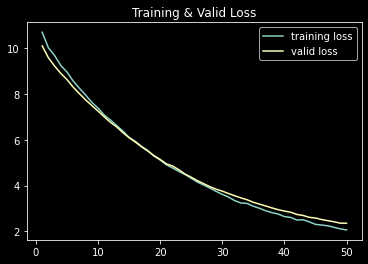

In [179]:
plot_loss(history)

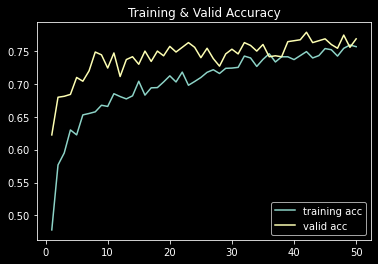

In [180]:
plot_acc(history)

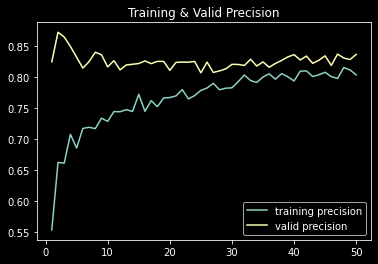

In [181]:
plot_precision(history)

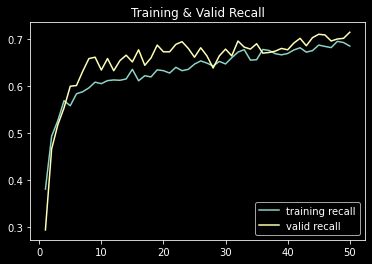

In [182]:
plot_recall(history)

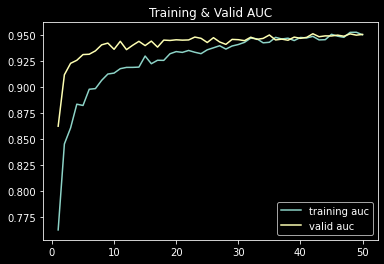

In [183]:
plot_auc(history)

### Evaluate model

In [184]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 489ms/step - loss: 1.9123 - categorical_accuracy: 0.7682 - precision: 0.8358 - recall: 0.7139 - auc: 0.9508


[1.9122628352858804, 0.76824033, 0.8358459, 0.71387696, 0.9507794]

In [185]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [186]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 625ms/step


In [187]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.97      0.95       360
         mild       0.51      0.46      0.48        67
     moderate       0.72      0.65      0.69       184
       severe       0.23      0.26      0.25        34
proliferative       0.46      0.52      0.49        54

     accuracy                           0.77       699
    macro avg       0.57      0.57      0.57       699
 weighted avg       0.77      0.77      0.77       699



In [188]:
confusion_matrix(y_true, y_pred)

array([[349,   6,   5,   0,   0],
       [ 13,  31,  17,   1,   5],
       [  9,  18, 120,  21,  16],
       [  1,   1,  11,   9,  12],
       [  0,   5,  13,   8,  28]], dtype=int64)

## Fine Tune

In [189]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [190]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [191]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [192]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0384 - categorical_accuracy: 0.7600 - precision: 0.8130 - recall: 0.6961 - auc: 0.9532
Epoch 00001: val_loss improved from inf to 2.36617, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold5\best_fine_tune-20201211.h5
88/88 [==============================] - 137s 2s/step - loss: 2.0353 - categorical_accuracy: 0.7592 - precision: 0.8122 - recall: 0.6952 - auc: 0.9530 - val_loss: 2.3662 - val_categorical_accuracy: 0.7625 - val_precision: 0.8364 - val_recall: 0.7167 - val_auc: 0.9505
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0253 - categorical_accuracy: 0.7568 - precision: 0.8124 - recall: 0.6917 - auc: 0.9529
Epoch 00002: val_loss improved from 2.36617 to 2.35627, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_green/fold5\best_

87/88 [============================>.] - ETA: 1s - loss: 1.8699 - categorical_accuracy: 0.7944 - precision: 0.8473 - recall: 0.7340 - auc: 0.9655
Epoch 00031: val_loss did not improve from 2.29317
88/88 [==============================] - 119s 1s/step - loss: 1.8718 - categorical_accuracy: 0.7942 - precision: 0.8467 - recall: 0.7342 - auc: 0.9655 - val_loss: 2.3044 - val_categorical_accuracy: 0.7740 - val_precision: 0.8189 - val_recall: 0.7310 - val_auc: 0.9544
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.8852 - categorical_accuracy: 0.7922 - precision: 0.8393 - recall: 0.7286 - auc: 0.9655
Epoch 00032: val_loss did not improve from 2.29317
88/88 [==============================] - 119s 1s/step - loss: 1.8863 - categorical_accuracy: 0.7928 - precision: 0.8402 - recall: 0.7288 - auc: 0.9656 - val_loss: 2.2989 - val_categorical_accuracy: 0.7754 - val_precision: 0.8205 - val_recall: 0.7325 - val_auc: 0.9543
Epoch 33/50
87/88 [============================>.] - ETA: 

Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.8269 - categorical_accuracy: 0.7978 - precision: 0.8376 - recall: 0.7468 - auc: 0.9669
Epoch 00048: val_loss did not improve from 2.28937
88/88 [==============================] - 120s 1s/step - loss: 1.8231 - categorical_accuracy: 0.7981 - precision: 0.8377 - recall: 0.7471 - auc: 0.9670 - val_loss: 2.3137 - val_categorical_accuracy: 0.7754 - val_precision: 0.8243 - val_recall: 0.7382 - val_auc: 0.9560
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.8527 - categorical_accuracy: 0.7882 - precision: 0.8341 - recall: 0.7467 - auc: 0.9646
Epoch 00049: val_loss did not improve from 2.28937
88/88 [==============================] - 123s 1s/step - loss: 1.8511 - categorical_accuracy: 0.7889 - precision: 0.8351 - recall: 0.7471 - auc: 0.9647 - val_loss: 2.3061 - val_categorical_accuracy: 0.7711 - val_precision: 0.8172 - val_recall: 0.7353 - val_auc: 0.9561
Epoch 50/50
87/88 [===========================

In [193]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

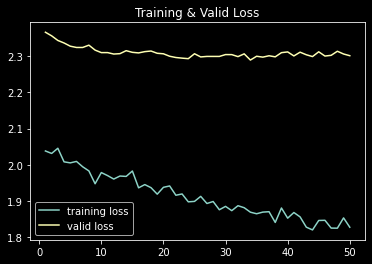

In [194]:
plot_loss(history)

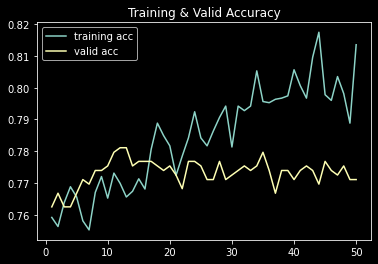

In [195]:
plot_acc(history)

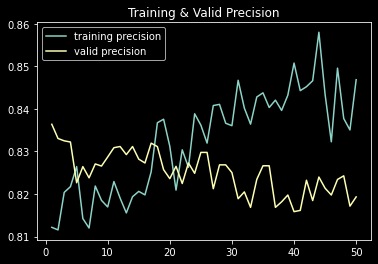

In [196]:
plot_precision(history)

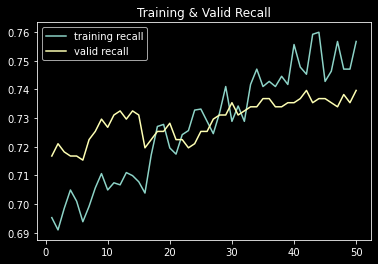

In [197]:
plot_recall(history)

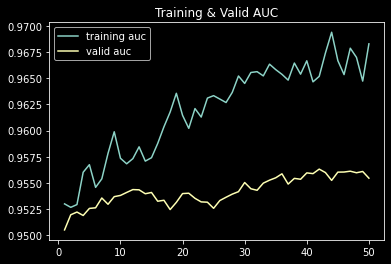

In [198]:
plot_auc(history)

### Evaluate model

In [199]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 499ms/step - loss: 1.8254 - categorical_accuracy: 0.7711 - precision: 0.8193 - recall: 0.7396 - auc: 0.9555


[1.825353573669087, 0.7711016, 0.8193344, 0.739628, 0.9554542]

In [200]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [201]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 436ms/step


In [202]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.97      0.95       360
         mild       0.49      0.49      0.49        67
     moderate       0.75      0.65      0.69       184
       severe       0.23      0.26      0.25        34
proliferative       0.48      0.56      0.51        54

     accuracy                           0.77       699
    macro avg       0.58      0.59      0.58       699
 weighted avg       0.78      0.77      0.77       699



In [203]:
confusion_matrix(y_true, y_pred)

array([[348,   8,   3,   0,   1],
       [ 13,  33,  17,   1,   3],
       [  9,  20, 119,  19,  17],
       [  1,   1,  11,   9,  12],
       [  0,   5,   9,  10,  30]], dtype=int64)